# Machine learning assignment 4: k-means Cluster Analysis

## Loading data

In [5]:
%matplotlib inline
import numpy
import pandas
from pandas import Series, DataFrame
from sklearn import preprocessing
from sklearn.cluster import KMeans

data = pandas.read_csv('hour.csv', low_memory=False)
print("Number of observations: ", len(data))
data.head()

Number of observations:  17379


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
seasmap = {1: '1. Winter', 2:'2. Spring', 3:'3. Summer', 4:'4. Fall'}
data['season'] = data['season'].map(seasmap)
selected_vars = ['temp','hum','windspeed']
cluster = data[selected_vars].copy()
for i in selected_vars:
    cluster[i] = preprocessing.scale(cluster[i].astype('float64'))

In [7]:
from sklearn.cross_validation import train_test_split
clus_train, clus_test = train_test_split(cluster, test_size=.3, random_state=123)

In [8]:
from scipy.spatial.distance import cdist
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(numpy.mean(numpy.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)))

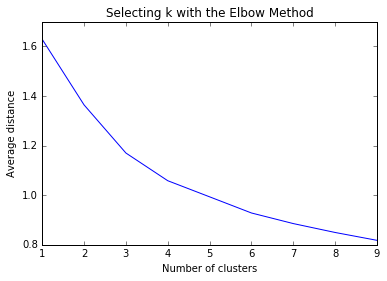

In [9]:
import matplotlib.pylab as plt
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method');

In [10]:
model3=KMeans(n_clusters=3)
model3.fit(clus_train)
clusassign=model3.predict(clus_train)

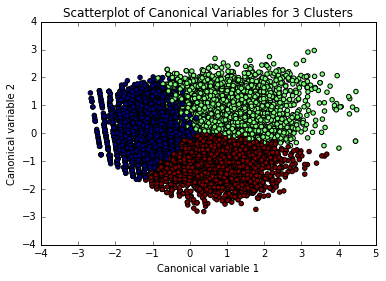

In [11]:
from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

In [12]:
clus_train.reset_index(level=0, inplace=True)

In [13]:
cluslist=list(clus_train['index'])
labels=list(model3.labels_)
newlist=dict(zip(cluslist, labels))
newclus=DataFrame.from_dict(newlist, orient='index')
newclus.columns = ['cluster']
newclus.head()

,cluster
0,0
1,0
2,0
3,0
4,0


In [14]:
newclus.reset_index(level=0, inplace=True)

In [15]:
merged_train=pandas.merge(clus_train, newclus, on='index')
merged_train.head(n=20)

,index,temp,hum,windspeed,cluster
0,1859,-0.815304,1.258375,0.519896,0
1,7302,-0.919172,0.169865,-1.553889,0
2,17094,-0.919172,0.169865,-1.553889,0
3,17009,-0.607566,0.999206,0.031899,0
4,1636,-0.295959,-1.125980,1.374096,1
5,7831,-0.088222,0.480868,0.519896,0
6,11537,0.119516,-0.400306,-0.211691,2
7,12655,0.950466,-1.125980,-0.699689,2
8,2693,0.431122,1.310209,0.764304,0
9,10435,0.119516,0.273533,-0.456099,0


In [16]:
merged_train.cluster.value_counts()

0    5014
2    3693
1    3458
Name: cluster, dtype: int64

In [17]:
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

Clustering variable means by cluster
               index      temp       hum  windspeed
cluster                                            
0        8887.398085 -0.225443  0.864163  -0.558910
1        7843.412955 -0.834648 -0.726779   0.731727
2        9182.403195  1.073264 -0.508297   0.077095


## Validate by weathersituation
The dataset contains a variable weathersit which is a label for the weather situation at that observation. Values for this label are:
 * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
 * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
 * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
 * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
 
I would like to see if this weathersituation is captured by the clustering of the weather variables.

In [85]:
ws_data=data[['weathersit']]
# split ws data into train and test sets
ws_train, ws_test = train_test_split(ws_data, test_size=.3, random_state=123)
ws_train1=pandas.DataFrame(ws_train)
ws_train1.reset_index(level=0, inplace=True)
merged_train_all=pandas.merge(ws_train1, merged_train, on='index')
sub1 = merged_train_all[['weathersit','cluster']].dropna()

In [86]:
pandas.crosstab(sub1.weathersit, sub1.cluster)

cluster,0,1,2
weathersit,,,
1,2524,2538,2926
2,1758,763,666
3,731,157,101
4,1,0,0


Since weathersituation 4 only occurs once in the training data, I merge it with weather situation 3.

In [87]:
sub1['weathersit'] = sub1['weathersit'].map({1:1,2:2,3:3,4:3})

The cross table then looks as follows:

In [88]:
ct = pandas.crosstab(sub1.weathersit, sub1.cluster)
print(ct)
colsum=ct.sum(axis=0)
colpct=ct/colsum
print(colpct)

cluster        0     1     2
weathersit                  
1           2524  2538  2926
2           1758   763   666
3            732   157   101
cluster            0         1         2
weathersit                              
1           0.503391  0.733950  0.792310
2           0.350618  0.220648  0.180341
3           0.145991  0.045402  0.027349


It looks like the clusters are associated with weathersituation, with cluster 0 capturing the worst weather, cluster 1 capturing better weather and cluster 3 capturing the 'best' weather. I conduct a Chi^2 test to examine this closer.

In [89]:
import scipy.stats
print ('chi-square value, p value, expected counts')
scipy.stats.chi2_contingency(ct)

chi-square value, p value, expected counts


(1025.8777845090167,
 8.7979405782658813e-221,
 4,
 array([[ 3292.38240855,  2270.65384299,  2424.96374846],
        [ 1313.57320181,   905.93062063,   967.49617756],
        [  408.04438964,   281.41553637,   300.54007398]]))

The Chi-square test shows that weather situation is associated with the cluster. Post hoc tests are required to show how exactly.

In [90]:
numcomparisons = 0
table = pandas.DataFrame('-',index=range(0,3),columns=range(0,3))
for i in range(0,3):
    for j in range(i+1,3):
        sub2 = sub1[(sub1['cluster'] == i) | (sub1['cluster'] == j)]
        ct = pandas.crosstab(sub2.weathersit, sub2.cluster)    
        chi2, p, dof, ex = scipy.stats.chi2_contingency(ct)
        numcomparisons = numcomparisons+1
        table.iloc[j,i] = p

print("number of comparisons ",numcomparisons)
pcritical = 0.05/numcomparisons
print("Bonferroni corrected critical p: ",pcritical)
table

number of comparisons  3
Bonferroni corrected critical p:  0.016666666666666666


,0,1,2
0,-,-,-
1,2.41714e-108,-,-
2,2.37844e-178,4.12925e-09,-


The post-hoc test shows that all pairs of clusters are significantly different in the proportion of assigned weather situations. Another posthoc test is required to show how exactly.

In [92]:
numcomparisons = 0
colnames = []
rownames = []
table = pandas.DataFrame('-',index=range(0,3),columns=range(0,3))
for cl1 in range(0,3):
    for cl2 in range(cl1+1,3):
        colnames.append("cluster "+str(cl1)+" vs "+str(cl2))
        for ws1 in range(0,3):
            for ws2 in range(ws1+1,3):
                rownames.append("weathersit "+str(ws1)+","+str(ws2))
                sub2 = sub1[(sub1['cluster'] == cl1) | (sub1['cluster'] == cl2)|(sub1['weathersit'] == ws1) | (sub1['weathersit'] == ws2)]
                ct = pandas.crosstab(sub2.weathersit, sub2.cluster)    
                chi2, p, dof, ex = scipy.stats.chi2_contingency(ct)
                numcomparisons = numcomparisons+1                
                table.iloc[cl1+cl2-1,ws1+ws2-1] = p

print("number of comparisons ",numcomparisons)
pcritical = 0.05/numcomparisons
print("Bonferroni corrected critical p: ",pcritical)
table.columns = colnames
table.index = rownames[0:3]
table

number of comparisons  9
Bonferroni corrected critical p:  0.005555555555555556


,cluster 0 vs 1,cluster 0 vs 2,cluster 1 vs 2
"weathersit 0,1",0,0,5.83853e-270
"weathersit 0,2",0,0,6.56806e-289
"weathersit 1,2",2.38469e-165,0,1.74402e-159


In [83]:
table.index

RangeIndex(start=0, stop=3, step=1)

The final posthoc test shows that all pairs of clusters are significantly different in the proportion of assigned weather situations for all pairs of weathersituations.

## Validate by season

In [93]:
ws_data=data[['season']]
# split ws data into train and test sets
ws_train, ws_test = train_test_split(ws_data, test_size=.3, random_state=123)
ws_train1=pandas.DataFrame(ws_train)
ws_train1.reset_index(level=0, inplace=True)
merged_train_all=pandas.merge(ws_train1, merged_train, on='index')
sub1 = merged_train_all[['season','cluster']].dropna()

In [94]:
ct = pandas.crosstab(sub1.season, sub1.cluster)
print(ct)
colsum=ct.sum(axis=0)
colpct=ct/colsum
print(colpct)

cluster       0     1     2
season                     
1. Winter  1096  1848    88
2. Spring  1275   634  1162
3. Summer  1021    34  2090
4. Fall    1622   942   353
cluster           0         1         2
season                                 
1. Winter  0.218588  0.534413  0.023829
2. Spring  0.254288  0.183343  0.314649
3. Summer  0.203630  0.009832  0.565936
4. Fall    0.323494  0.272412  0.095586


Cluster 0 seems to be mostly assigned to Fall and Spring, cluster 1 to Winter and Fall, cluster 2 to Summer and Spring. I conduct a Chi^2 test to examine this closer.

In [95]:
import scipy.stats
print ('chi-square value, p value, expected counts')
scipy.stats.chi2_contingency(ct)

chi-square value, p value, expected counts


(4739.8833376772436,
 0.0,
 6,
 array([[ 1249.68746404,   861.87061241,   920.44192355],
        [ 1265.76193999,   872.956679  ,   932.28138101],
        [ 1296.2622277 ,   893.9917797 ,   954.7459926 ],
        [ 1202.28836827,   829.18092889,   885.53070284]]))

The Chi-square test shows that season is associated with the cluster. Post hoc tests are required to show how exactly.

In [96]:
numcomparisons = 0
table = pandas.DataFrame('-',index=range(0,3),columns=range(0,3))
for i in range(0,3):
    for j in range(i+1,3):
        sub2 = sub1[(sub1['cluster'] == i) | (sub1['cluster'] == j)]
        ct = pandas.crosstab(sub2.season, sub2.cluster)    
        chi2, p, dof, ex = scipy.stats.chi2_contingency(ct)
        numcomparisons = numcomparisons+1
        table.iloc[j,i] = p

print("number of comparisons ",numcomparisons)
pcritical = 0.05/numcomparisons
print("Bonferroni corrected critical p: ",pcritical)
table

number of comparisons  3
Bonferroni corrected critical p:  0.016666666666666666


,0,1,2
0,-,-,-
1,1.26618e-274,-,-
2,0,0,-


The post-hoc test shows that all pairs of clusters are significantly different in the proportion of seasons. Another posthoc test is required to show how exactly.

In [104]:
numcomparisons = 0
colnames = []
rownames = []
table = pandas.DataFrame('-',index=range(0,6),columns=range(0,3))
for cl1 in range(0,3):
    for cl2 in range(cl1+1,3):
        colnames.append("cluster "+str(cl1)+" vs "+str(cl2))
        i = 0
        for s1 in range(0,4):
            for s2 in range(s1+1,4):
                rownames.append(seasmap[s1+1]+","+seasmap[s2+1])
                sub2 = sub1[(sub1['cluster'] == cl1) | (sub1['cluster'] == cl2)|(sub1['season'] == seasmap[s1+1]) | (sub1['season'] == seasmap[s2+1])]
                ct = pandas.crosstab(sub2.season, sub2.cluster)    
                chi2, p, dof, ex = scipy.stats.chi2_contingency(ct)
                numcomparisons = numcomparisons+1                                
                table.iloc[i,cl1+cl2-1] = p
                i = i+1

print("number of comparisons ",numcomparisons)
pcritical = 0.05/numcomparisons
print("Bonferroni corrected critical p: ",pcritical)
table.columns = colnames
table.index = rownames[0:6]
table

number of comparisons  18
Bonferroni corrected critical p:  0.002777777777777778


,cluster 0 vs 1,cluster 0 vs 2,cluster 1 vs 2
"1. Winter,2. Spring",0,0,0
"1. Winter,3. Summer",0,0,0
"1. Winter,4. Fall",0,0,0
"2. Spring,3. Summer",0,0,0
"2. Spring,4. Fall",0,0,0
"3. Summer,4. Fall",0,0,0


The final posthoc test shows that all pairs of clusters are significantly different in the proportion of seasons for all pairs of seasons.